In [1]:
import sys
from math import pi

import matplotlib.pyplot as plt
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
sys.path.append('../')
import dstft
from dstft.loss import entropy_loss
from dstft import DSTFT, DSpec

torch.Size([1, 25000])


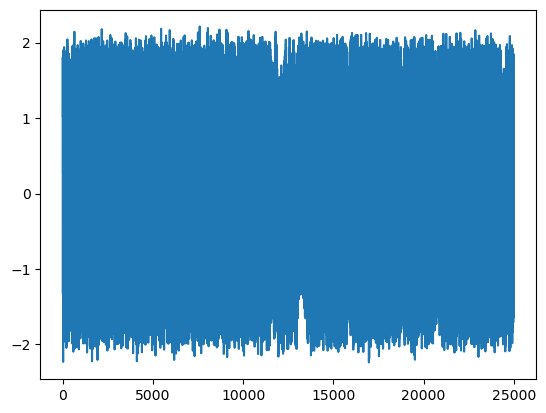

In [3]:
sr = 1e4
t = torch.arange(0, 2.5, 1/sr)
f = torch.sin(2*pi*t) * 1e2 + 1e2 * torch.ones_like(t) + 5e1 * t
x = (torch.sin(torch.cumsum(f, dim=0) / 2e2) + 0.1 *torch.randn(t.shape))[None, :]
x += torch.sin(torch.cumsum(1e2*5 * torch.ones_like(t), dim=0) / 2e2)
x = x.to(device)

print(x.shape)
plt.plot(x[0].cpu())

Text(0.5, 0, 'frames')

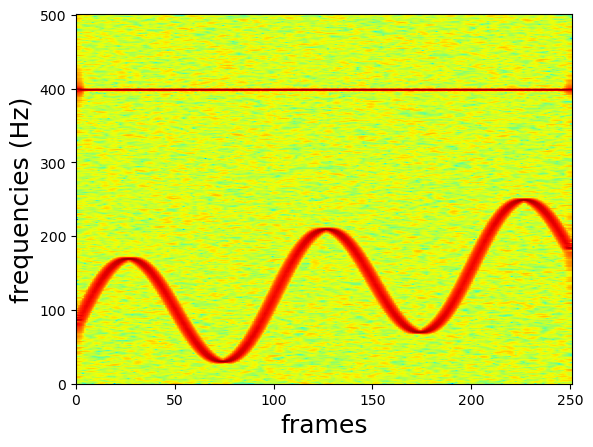

In [9]:
spec = torchaudio.transforms.Spectrogram(n_fft=1_000, win_length=1_000, hop_length=100)(x.cpu())
plt.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

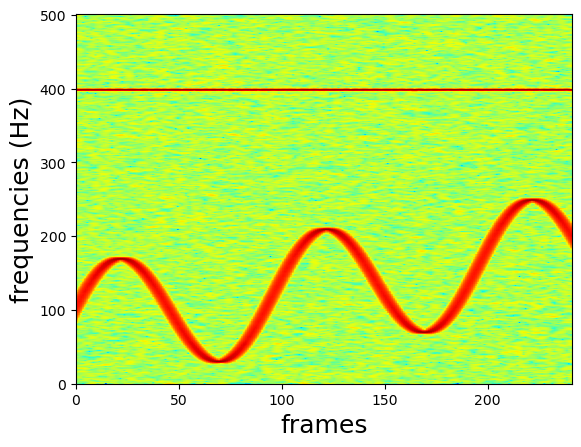

In [5]:
dstft = DSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False)

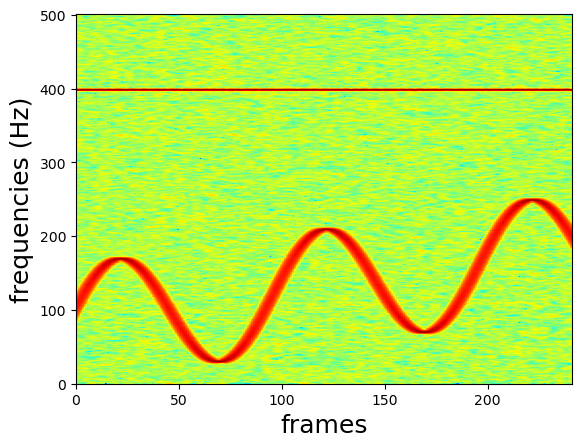

In [6]:
dspec = DSpec(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec = dspec(x)
dspec.print(spec, weights=False, wins=False)

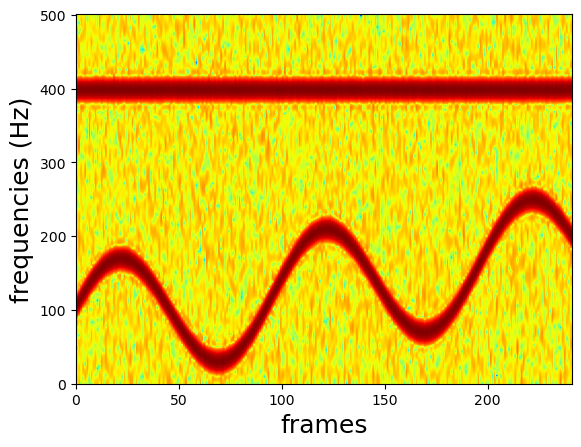

In [7]:
dspec = DSpec(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec = dspec(x)
dspec.print(spec, weights=False, wins=False)

9


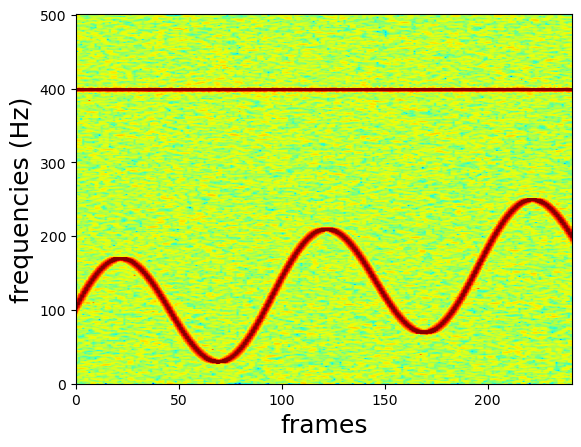

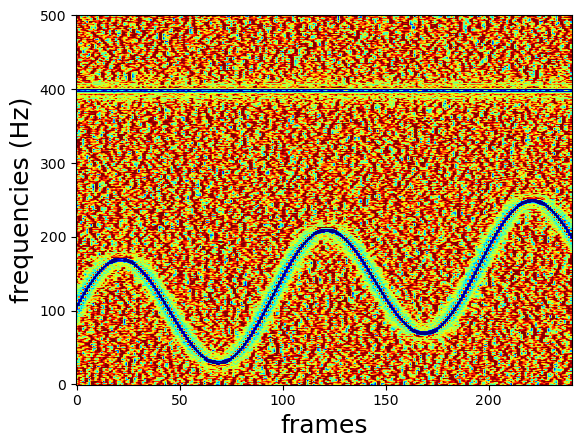

In [8]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf')
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=10, verbose=True)

for epoch in range(10):
    opt.zero_grad()
    spec, _, _, _, _ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
print(epoch)
dstft.print(spec, wins=False)
spec1 = spec